In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyxdf

%matplotlib inline

# Analyze screen flicker delay/jitter

## Load lsl recording

In [2]:
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-Default_run-002_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_run-001_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_run-002_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_run-005_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_psychopy_run-001_eeg.xdf'
fpath = 'C:/Users/Experiment/Documents/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg.xdf'
# fpath = 'C:/Users/Experiment/Documents/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg_old1.xdf'
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg.xdf"
streams, header = pyxdf.load_xdf(fpath, dejitter_timestamps=False)

for stream in streams:
    print(stream['info']['name'])

['ScreenSensorStream']
['ScreenSequenceStream']


In [3]:
sequence_stream = [s for s in streams if s['info']['name'][0] == 'ScreenSequenceStream'][0]
sensor_stream = [s for s in streams if s['info']['name'][0] == 'ScreenSensorStream'][0]

In [4]:
%matplotlib qt

timestamps = sequence_stream['time_stamps']
timeseries = np.array(sequence_stream['time_series']).ravel()
timestamps_sensor = sensor_stream['time_stamps']
print('LSL Timestamps:', timestamps.shape)
print('Sensor timestamps', timestamps_sensor.shape)



# plt.scatter(timestamps, np.ones_like(timestamps), label='expected', marker='o')
# plt.scatter(timestamps_sensor, np.ones_like(timestamps_sensor), label='actual', marker='x')
# plt.legend()
# plt.show()

LSL Timestamps: (10002,)
Sensor timestamps (369583,)


In [5]:
start_timestamp = timestamps[timeseries == 'Start'][0]
start_timestamp

1921566.052920914

In [6]:
end_timestamp = timestamps[timeseries == 'end'][0]
end_timestamp

1922032.816195682

In [7]:
timestamps = timestamps[timestamps > start_timestamp]
timestamps = timestamps[timestamps < end_timestamp]
print(timestamps.shape)

(10000,)


In [8]:
timestamps_sensor = timestamps_sensor[timestamps_sensor > start_timestamp]
timestamps_sensor = timestamps_sensor[timestamps_sensor < end_timestamp]
print(timestamps_sensor.shape)

(62869,)


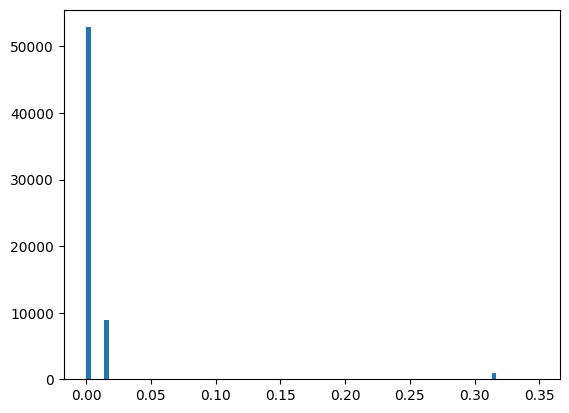

In [9]:
%matplotlib inline
plt.hist(np.diff(timestamps_sensor), bins=100)
plt.show()

In [10]:
min_diff = 0.005
filtered = [timestamps_sensor[0]]

# Iterate and filter out timestamps_sensor that are too close
for ts in timestamps_sensor[1:]:
    if ts - filtered[-1] >= min_diff:
        filtered.append(ts)

# Convert back to NumPy array
merged_timestamps = np.array(filtered)

print("Original length:", len(timestamps_sensor))
print("Filtered length:", len(merged_timestamps))


Original length: 62869
Filtered length: 9997


In [11]:
%matplotlib qt
plt.scatter(timestamps, np.ones_like(timestamps), label='expected', marker='o')
plt.scatter(merged_timestamps, np.ones_like(merged_timestamps), label='actual', marker='x')
plt.legend()
plt.show()

In [13]:
# Start from 5th break
start_time = 1921566.7
timestamps = timestamps[timestamps >= start_time]
merged_timestamps = merged_timestamps[merged_timestamps >= start_time]

plt.scatter(timestamps, np.ones_like(timestamps), label='expected', marker='o')
plt.scatter(merged_timestamps, np.ones_like(merged_timestamps), label='actual', marker='x')
plt.legend()
plt.show()

print(timestamps.shape)
print(merged_timestamps.shape)

(9989,)
(9988,)


In [15]:
sns.boxplot(merged_timestamps - timestamps[:-1])

<Axes: >

In [15]:
merged_timestamps[-1]

1922032.8023652195